# Statistical Machine Learning: Project Simulations

Author: Pascal Dreieck

## Set Up

In [1]:
# Import

import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_blobs

from lightning.classification import SGDClassifier, SVRGClassifier, SAGAClassifier

RANDOM_STATE = 42

In [2]:
# Datasets

X0, Y0 = make_blobs(n_features=2, centers=2, cluster_std=1.0, random_state=RANDOM_STATE)
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=2, n_clusters_per_class=1, class_sep=1.25, random_state=RANDOM_STATE)
X2, Y2 = make_classification(n_features=2, n_redundant=0, n_informative=1, n_classes=2, n_clusters_per_class=1, class_sep=1.25, random_state=RANDOM_STATE)
X3, Y3 = make_classification(n_features=2, n_redundant=1, n_informative=1, n_classes=2, n_clusters_per_class=1, class_sep=1.25, random_state=RANDOM_STATE)
X4, Y4 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=2, n_clusters_per_class=2, class_sep=1.5, random_state=RANDOM_STATE)
X5, Y5 = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=2, n_clusters_per_class=2, class_sep=1.5, random_state=2*RANDOM_STATE)

DATASETS = [(X0, Y0), (X1, Y1), (X2, Y2), (X3, Y3), (X4, Y4), (X5, Y5)]

# Center at (0,0)
for Xn, Yn in DATASETS:
    Xn[:, 0] = Xn[:, 0] - Xn[:, 0].mean()
    Xn[:, 1] = Xn[:, 1] - Xn[:, 1].mean()

    Yn[:] = 2 * Yn[:] - 1

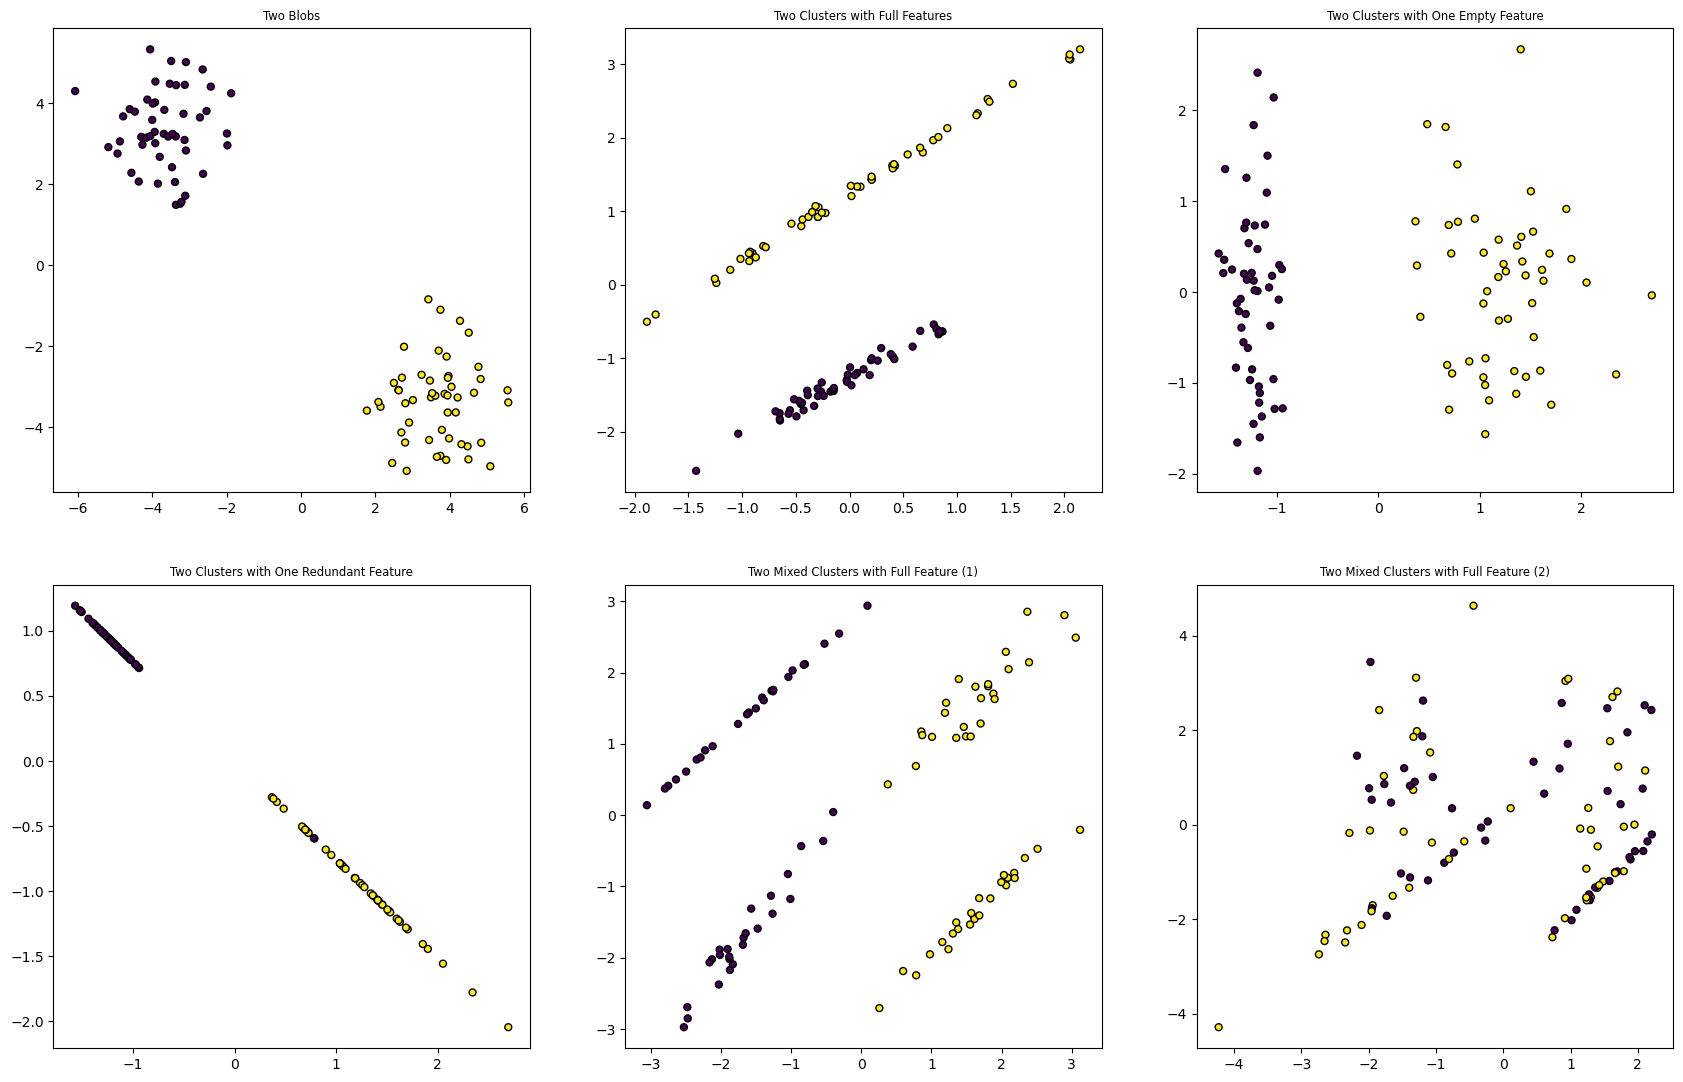

In [3]:
# Plot Datasets

fig = plt.figure(figsize=(18, 12))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

ax = fig.add_subplot(2, 3, 1)
ax.set_title("Two Blobs", fontsize="small")
ax.scatter(X0[:, 0], X0[:, 1], marker="o", c=Y0, s=25, edgecolor="k")

ax = fig.add_subplot(2, 3, 2)
ax.set_title("Two Clusters with Full Features", fontsize="small")
ax.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

ax = fig.add_subplot(2, 3, 3)
ax.set_title("Two Clusters with One Empty Feature", fontsize="small")
ax.scatter(X2[:, 0], X2[:, 1], marker="o", c=Y2, s=25, edgecolor="k")

ax = fig.add_subplot(2, 3, 4)
ax.set_title("Two Clusters with One Redundant Feature", fontsize="small")
ax.scatter(X3[:, 0], X3[:, 1], marker="o", c=Y3, s=25, edgecolor="k")

ax = fig.add_subplot(2, 3, 5)
ax.set_title("Two Mixed Clusters with Full Feature (1)", fontsize="small")
ax.scatter(X4[:, 0], X4[:, 1], marker="o", c=Y4, s=25, edgecolor="k")

ax = fig.add_subplot(2, 3, 6)
ax.set_title("Two Mixed Clusters with Full Feature (2)", fontsize="small")
ax.scatter(X5[:, 0], X5[:, 1], marker="o", c=Y4, s=25, edgecolor="k")

fig.savefig("plots/data.png")

In [4]:
# Mesh
xx, yy = np.meshgrid(np.linspace(-8, 8, 1000), np.linspace(-8, 8, 1000))

# Callback function for logging
class Callback(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.boundary = []
        self.loss = []
        self.times = []
        self.start_time = time.time()
        self.test_time = 0

    def __call__(self, clf):
        test_time = time.time()
        if hasattr(clf, "_finalize_coef"):
            clf._finalize_coef()
        y_pred = clf.decision_function(self.X).ravel()
        loss = (np.maximum(1 - self.y * y_pred, 0) ** 2).mean()
        coef = clf.coef_.ravel()
        regul = 0.5 * clf.alpha * np.dot(coef, coef)
        self.loss.append(loss + regul)
        self.test_time += time.time() - test_time
        self.times.append(time.time() -  self.start_time - self.test_time)

## Tests

In [5]:
# Plotting
colours = ["black", "crimson", "violet", "deepskyblue", "steelblue"]
linestyles = ['solid', 'dashed', 'dotted']

# TEST VALUES
ETAS = (1e-2, 1e-3, 1e-4, 1e-5, 1e-6)
ALPHAS = (1e0, 1e-1, 1e-2, 1e-3, 0)
N_INNERS = (1.0, 5.0, 10.0, 50.0, 100.0)
LOSSES = (('log', 'log'), ('hinge','smooth_hinge'), ('squared_hinge', 'squared_hinge'))

MAX_ITER = 100

#### Decision Boundary

In [6]:
# Test Values
eta = ETAS[-2]
alpha = ALPHAS[-1]
n_inner = N_INNERS[-3]
loss = LOSSES[0]

In [7]:
# Setup plot
fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

<Figure size 2500x2000 with 0 Axes>

In [8]:
# Snapshots
SNAPSHOTS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Run over all datasets
for i, tup in enumerate(DATASETS):
    Xn, Yn = tup

    cb_sgd = Callback(Xn, Yn)
    clf_sgd = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
        max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
    clf_sgd.fit(Xn, Yn)

    cb_svrg = Callback(Xn, Yn)
    clf_svrg = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
        max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
    clf_svrg.fit(Xn, Yn)
    
    cb_saga = Callback(Xn, Yn)
    clf_saga = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
        max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
    clf_saga.fit(Xn, Yn)

    cbs = [cb_saga, cb_svrg, cb_saga]

    for j, snap in enumerate(SNAPSHOTS):
        # Decision boundary subplot
        ax = fig.add_subplot(len(DATASETS), len(SNAPSHOTS), 1 + i * len(DATASETS) + j)
        ax.scatter(Xn[:, 0], Xn[:, 1], marker="o", c=Yn, s=25, edgecolor="k")

        # For each algorithm
        # for k, cb in enumerate(cbs):
        #     index = int(snap * len(cb.boundary))
        #     clf = cb.boundary[index]
        #     clf.fit(Xn, Yn)
        #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        #     Z = Z.reshape(xx.shape)
        #     _ = ax.contour(xx, yy, cb.boundary[index], levels=[0],
        #         c=colours[k], linestyle=linestyles[k], linewidth=1.5)
    
        if i == 0:
            ax.set_title(f"Snapshot {snap}", fontsize=15)
        
        if j == 0:
            ax.set_ylabel(f"Dataset {i}")

# Format and Save Plot
fig.suptitle(f"Training Decision Boundaries with SGD, SVRG, and SAGA", fontsize=20)
# fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.15), labelspacing=1.0, ncols = 5)
fig.savefig("plots/decision_boundaries.png", bbox_inches='tight')
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### Step Size Comparison

In [9]:
# Test Values
alpha = ALPHAS[-3]
n_inner = N_INNERS[-3]
loss = LOSSES[0]

Holy shit: (0, 0.005968752701275828), 0.005102261583870659
Holy shit: (1, 0.007179518986614007), 0.006868829304988179
Holy shit: (2, 0.007698127631306882), 0.0075598895477186415
Holy shit: (3, 0.007948408972648686), 0.00787875050352609
Holy shit: (4, 0.00807521461087289), 0.00804185247178037
Holy shit: (5, 0.008140642004002224), 0.008123716486118432
Holy shit: (6, 0.008174966728550661), 0.008166907871271048
Holy shit: (7, 0.008192998943829233), 0.00818925755603932
Holy shit: (8, 0.00820249398890567), 0.008200673578163979
Holy shit: (9, 0.008207520976990918), 0.008206598202624316
Holy shit: (0, 0.001957646491189977), 0.0018917950373808562
Holy shit: (1, 0.0029971923649906485), 0.002956098343191951
Holy shit: (2, 0.0036979955056745555), 0.0036686219694994204
Holy shit: (3, 0.004228324026493505), 0.004204455182717787
Holy shit: (4, 0.004653431296221345), 0.004634947742697742
Holy shit: (5, 0.005006702650078736), 0.004990982702860904
Holy shit: (6, 0.005307277660994691), 0.0052940668591028

<Figure size 640x480 with 0 Axes>

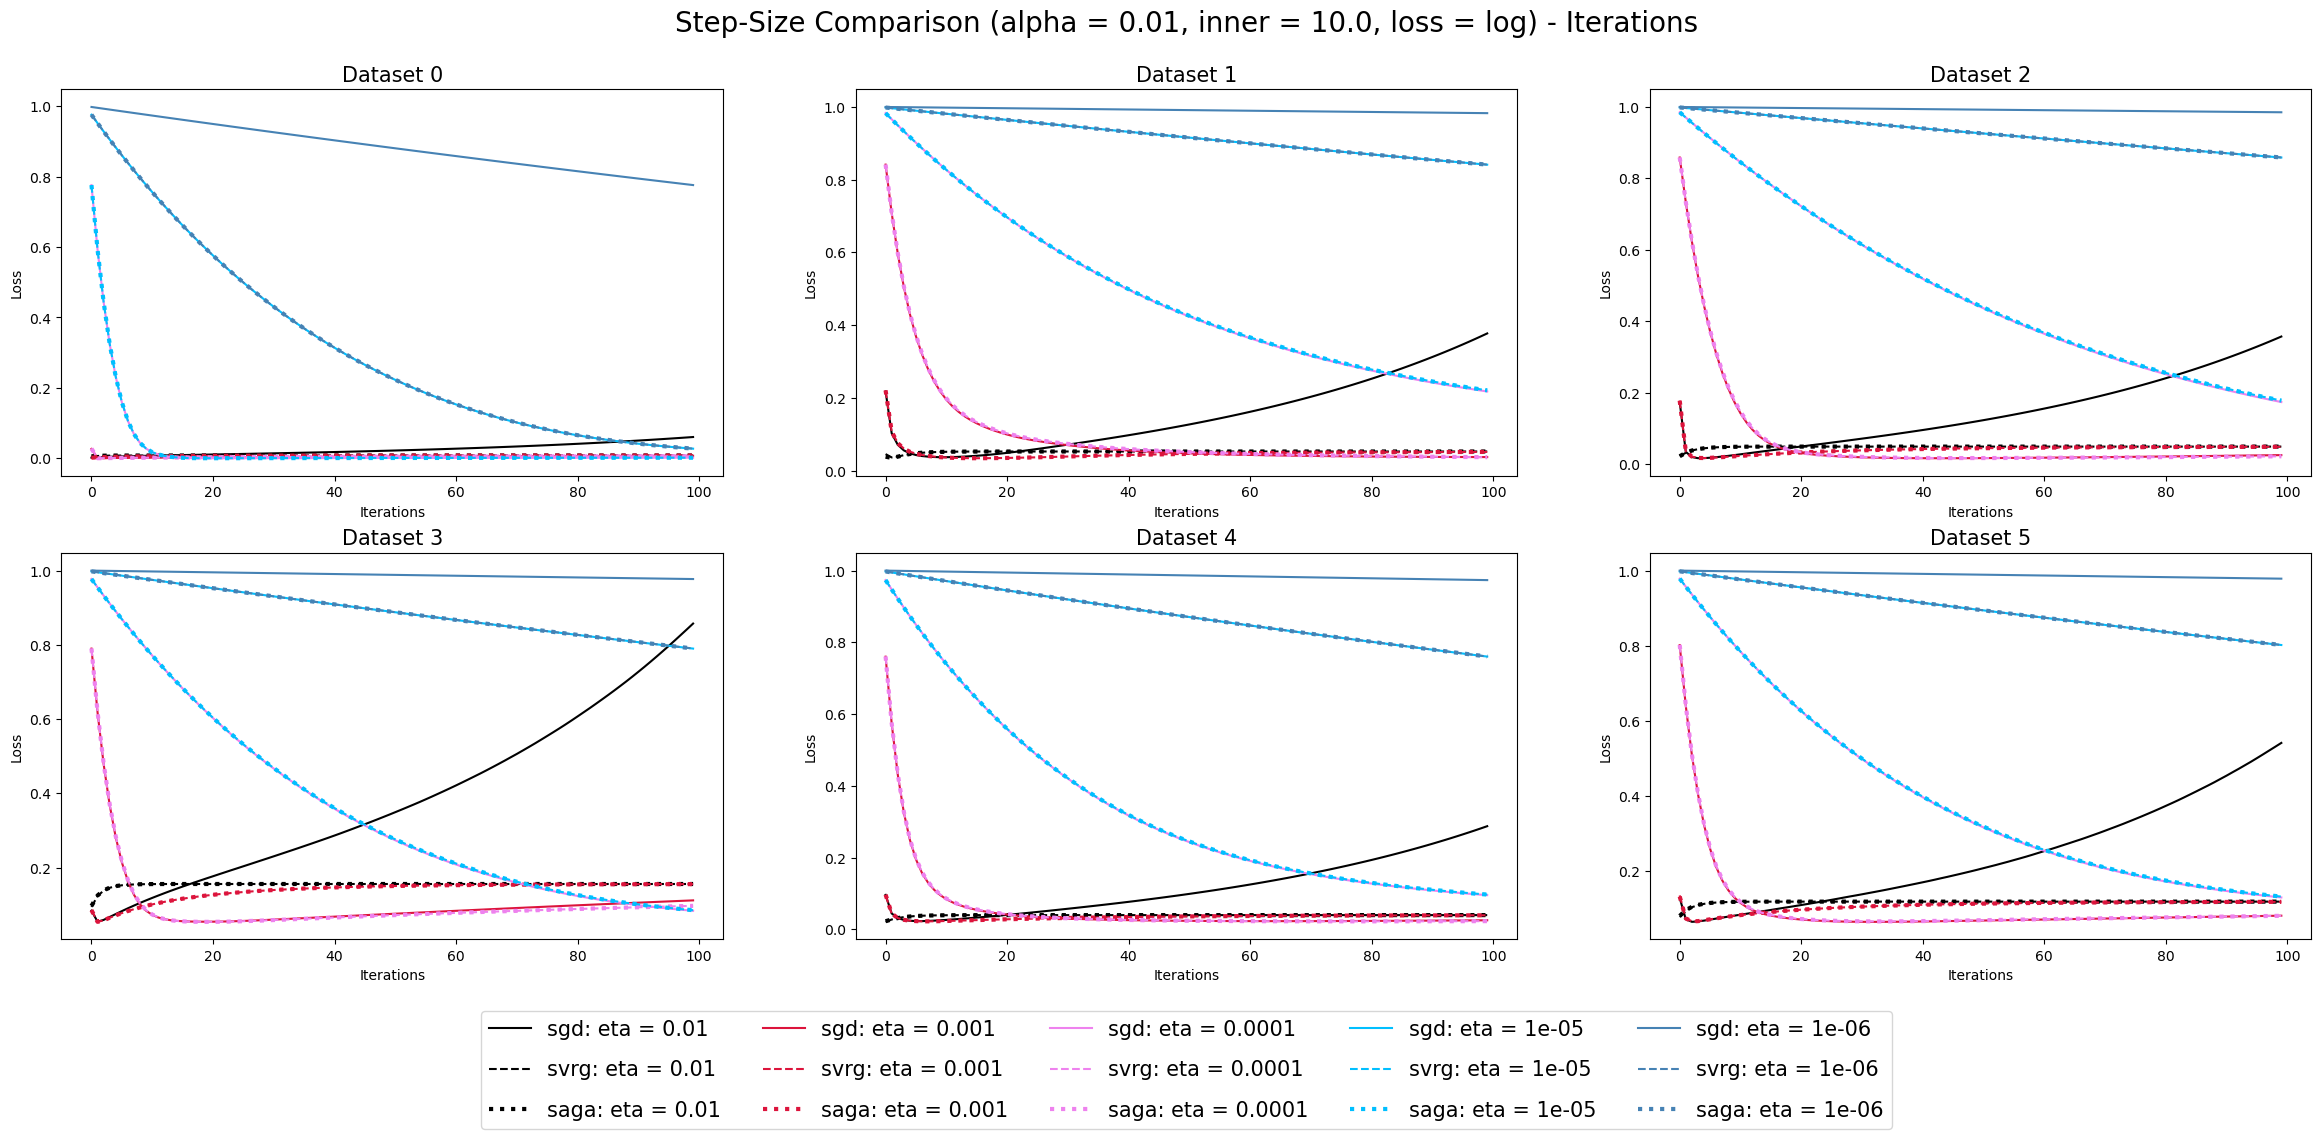

<Figure size 640x480 with 0 Axes>

In [10]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # Iteration Subplot
    ax = fig.add_subplot(2, 3, 1 + j)

    for i, eta in enumerate(ETAS):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_sgd.loss)), cb_sgd.loss,
            label=f"sgd: eta = {eta}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[0])

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_svrg.loss)), cb_svrg.loss,
            label=f"svrg: eta = {eta}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[1])
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_saga.loss)), cb_saga.loss,
            label=f"saga: eta = {eta}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[2], linewidth=3.0)
    
    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Step-Size Comparison (alpha = {alpha}, inner = {n_inner}, loss = {loss[0]}) - Iterations", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.15), labelspacing=1.0, ncols = 5)
fig.savefig("plots/eta_iterations.png", bbox_inches='tight')
plt.figure()

<Figure size 640x480 with 0 Axes>

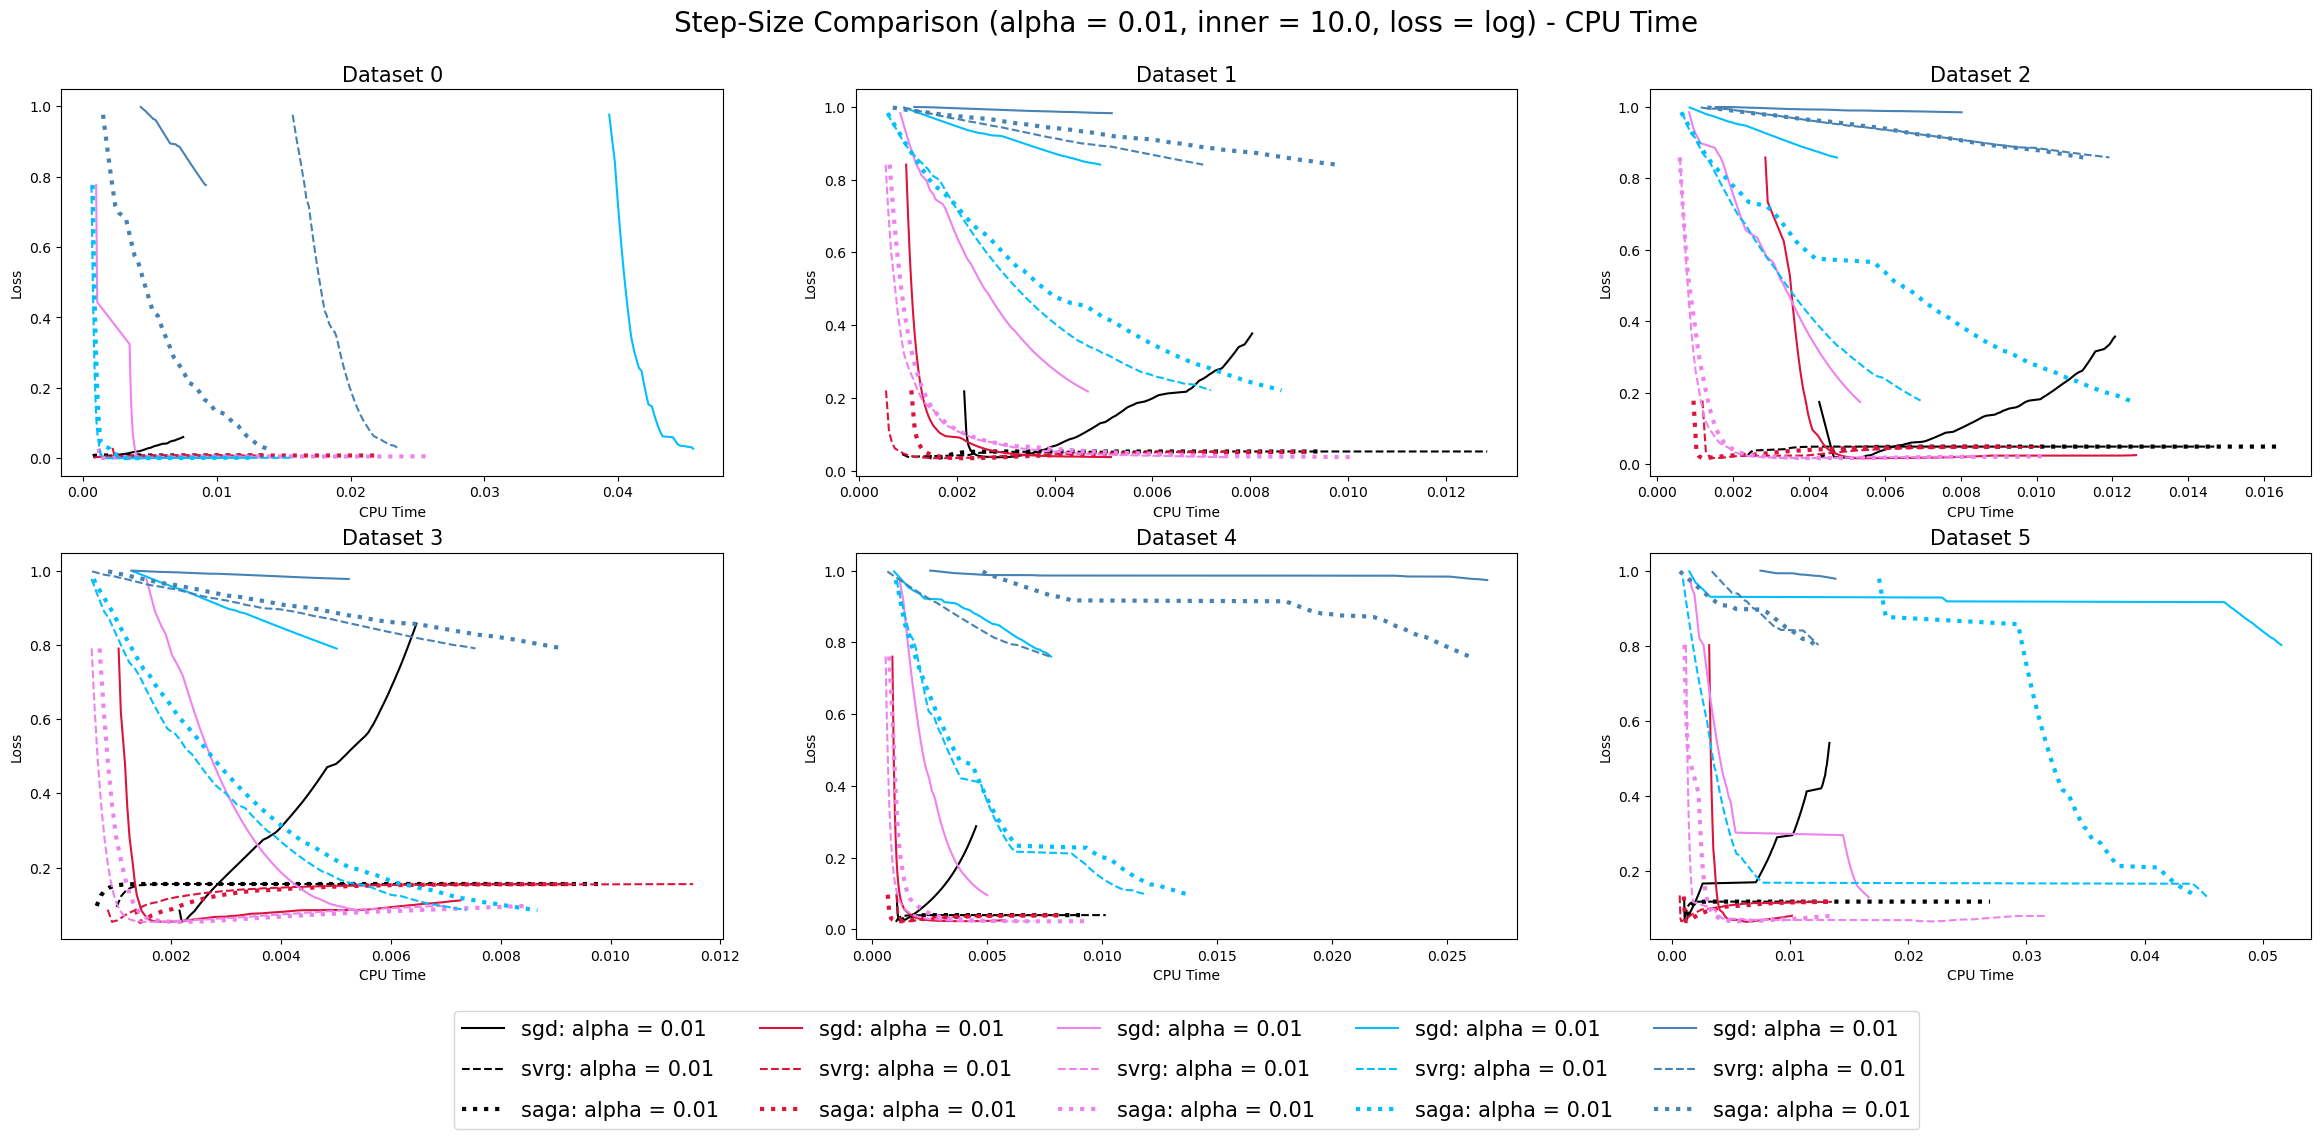

<Figure size 640x480 with 0 Axes>

In [11]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # CPU Time Subplot
    ax = fig.add_subplot(2, 3, 1 + j)
    for i, eta in enumerate(ETAS):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(cb_sgd.times, cb_sgd.loss,
            label=f"sgd: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[0])

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_svrg.times, cb_svrg.loss,
            label=f"svrg: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[1])
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_saga.times, cb_saga.loss,
            label=f"saga: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle=linestyles[2], linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("CPU Time")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Step-Size Comparison (alpha = {alpha}, inner = {n_inner}, loss = {loss[0]}) - CPU Time", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.15), labelspacing=1.0, ncols = 5)
fig.savefig("plots/eta_cpu_time.png", bbox_inches='tight')
plt.figure()

#### Regulariser Weighting Comparison

In [12]:
# Test Values
eta = ETAS[-2]
n_inner = N_INNERS[-1]
loss = LOSSES[0]

<Figure size 640x480 with 0 Axes>

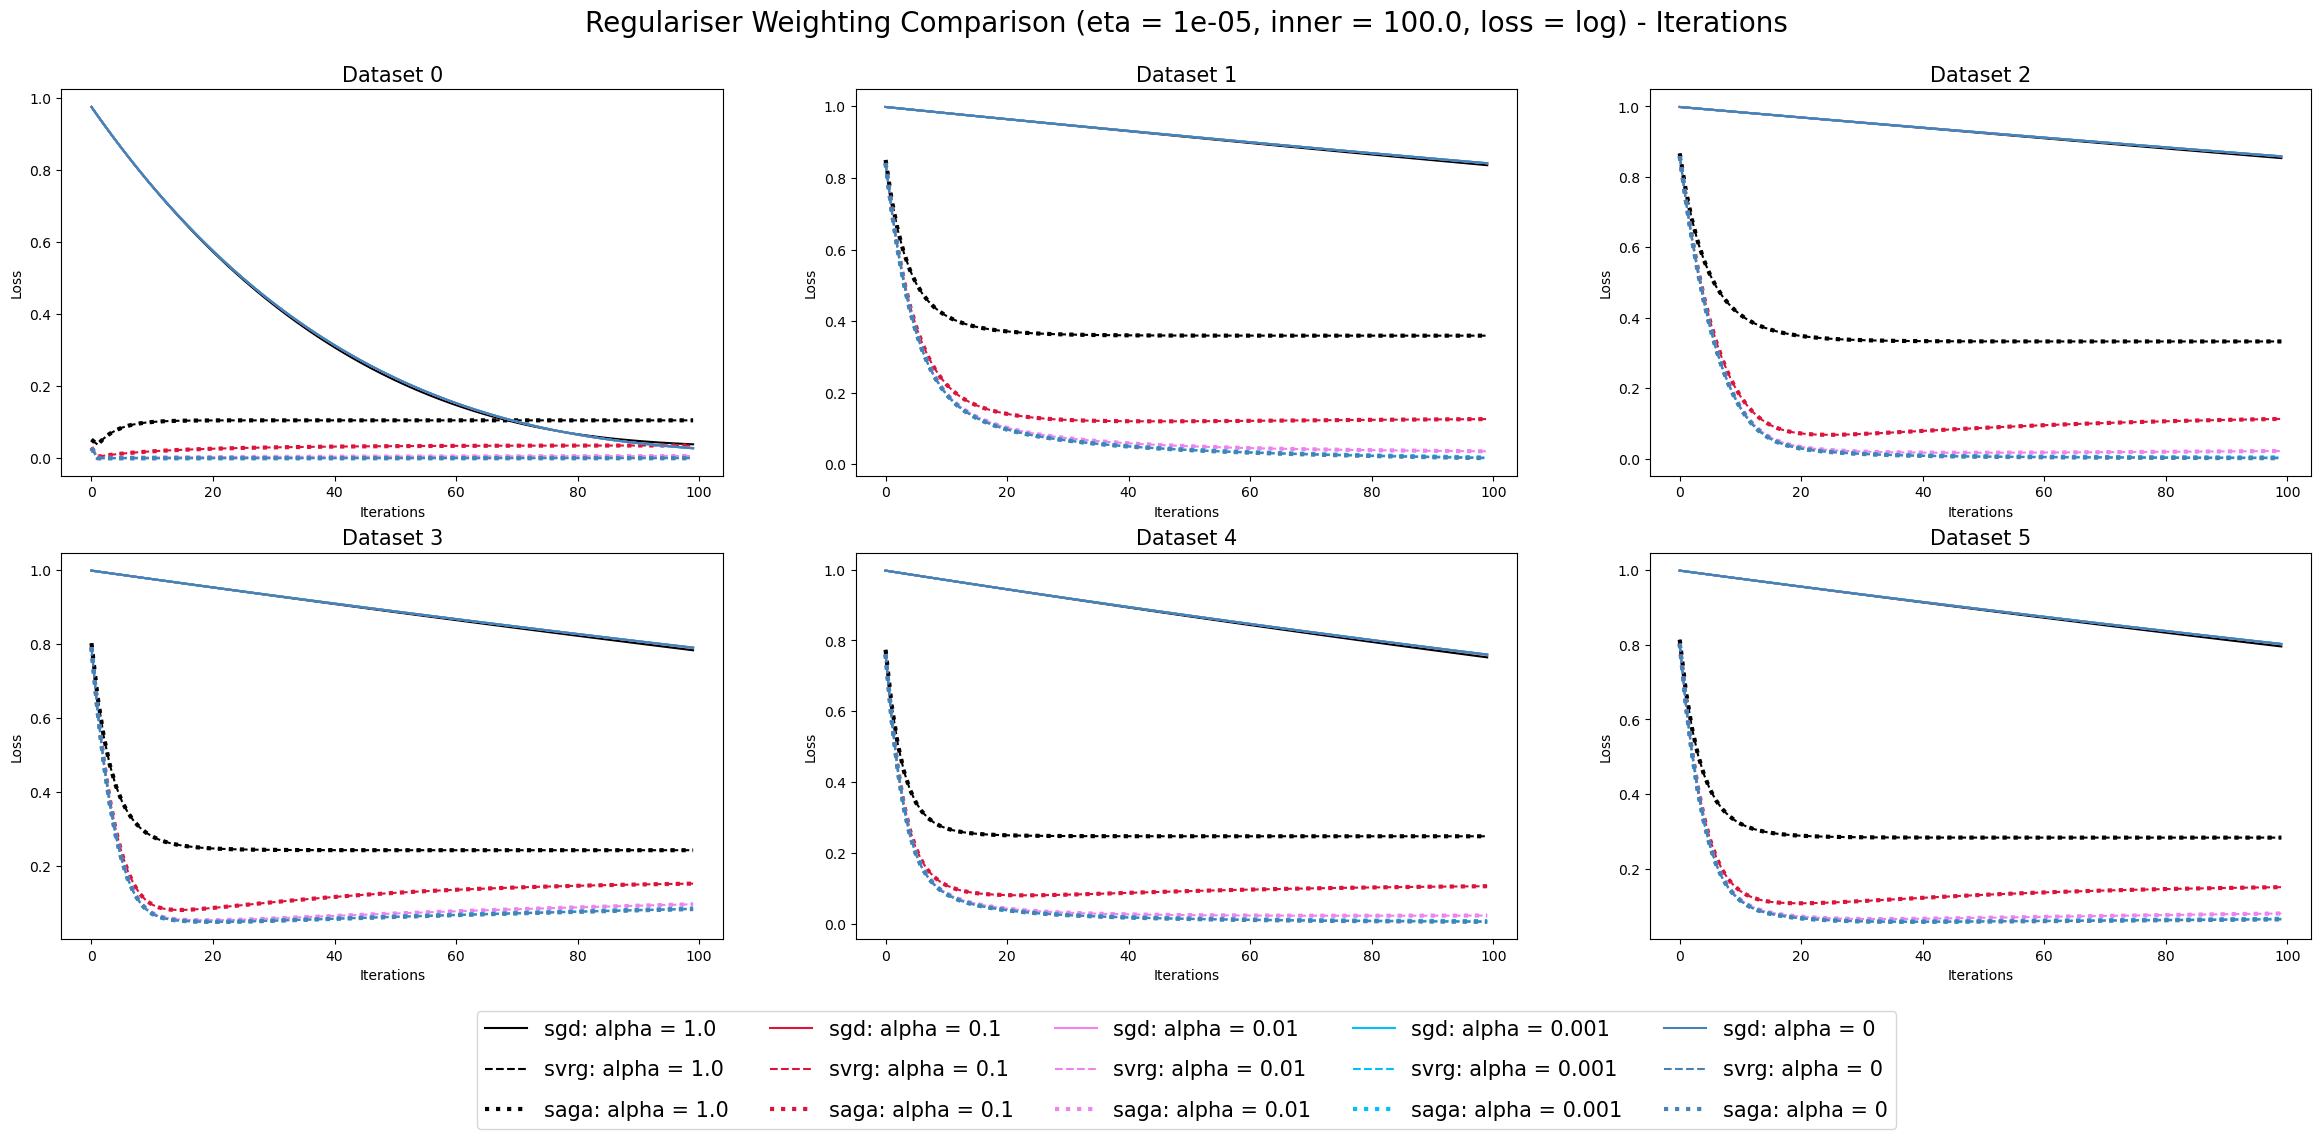

<Figure size 640x480 with 0 Axes>

In [13]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # Iteration Subplot
    ax = fig.add_subplot(2, 3, 1 + j)

    for i, alpha in enumerate(ALPHAS):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_sgd.loss)), cb_sgd.loss,
            label=f"sgd: alpha = {alpha}" if j == 0 else None,
            c=colours[i], )

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_svrg.loss)), cb_svrg.loss,
            label=f"svrg: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_saga.loss)), cb_saga.loss,
            label=f"saga: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Regulariser Weighting Comparison (eta = {eta}, inner = {n_inner}, loss = {loss[0]}) - Iterations", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.15), labelspacing=1.0, ncols = 5)
fig.savefig("plots/alpha_iterations.png", bbox_inches='tight')
plt.figure()

<Figure size 640x480 with 0 Axes>

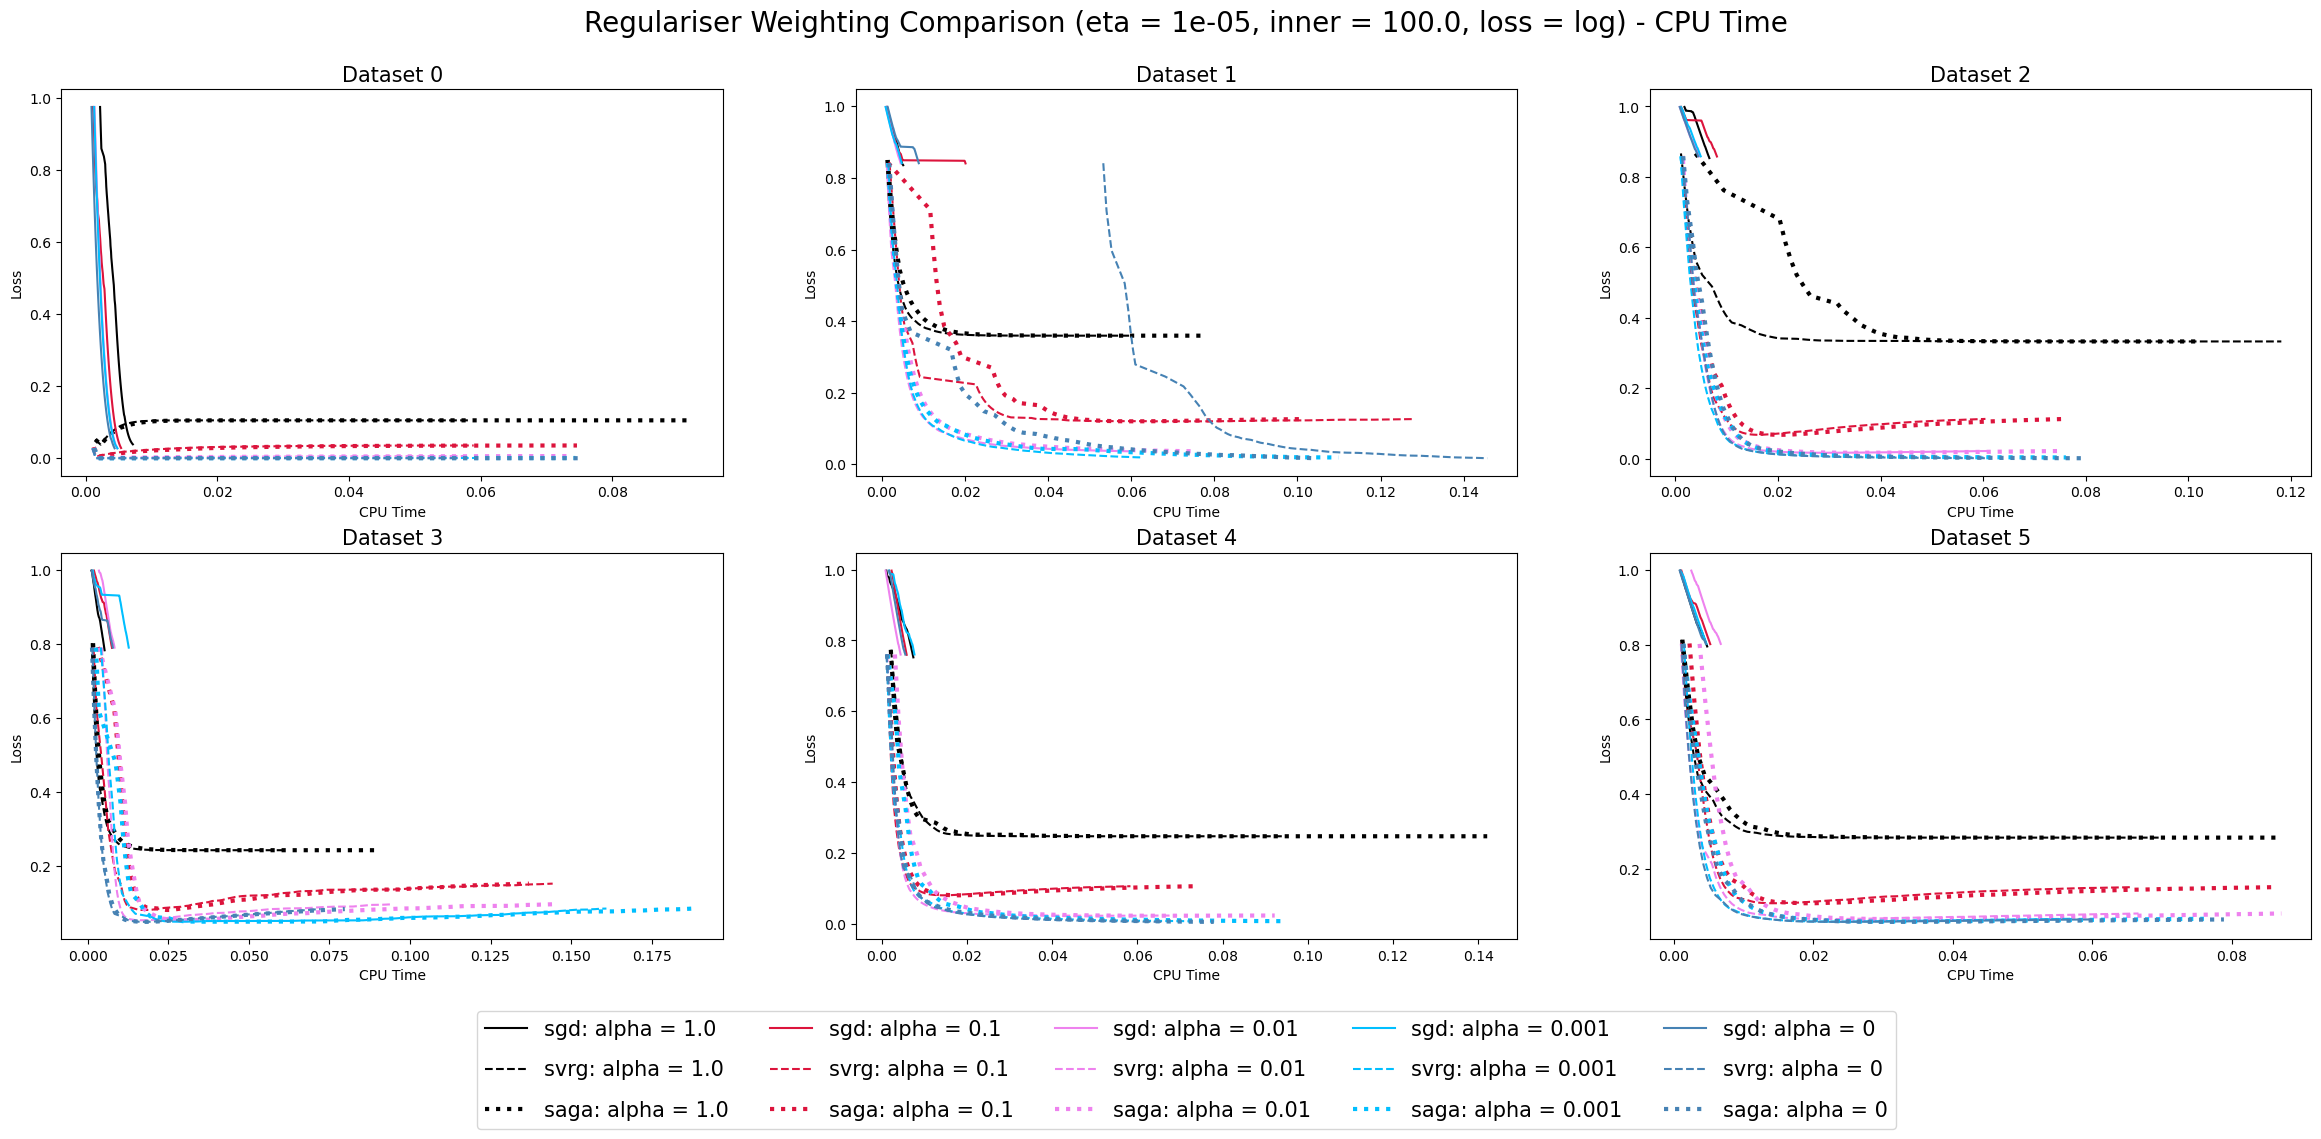

<Figure size 640x480 with 0 Axes>

In [14]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # CPU Time Subplot
    ax = fig.add_subplot(2, 3, 1 + j)

    for i, alpha in enumerate(ALPHAS):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(cb_sgd.times, cb_sgd.loss,
            label=f"sgd: alpha = {alpha}" if j == 0 else None,
            c=colours[i])

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_svrg.times, cb_svrg.loss,
            label=f"svrg: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_saga.times, cb_saga.loss,
            label=f"saga: alpha = {alpha}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("CPU Time")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Regulariser Weighting Comparison (eta = {eta}, inner = {n_inner}, loss = {loss[0]}) - CPU Time", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.15), labelspacing=1.0, ncols = 5)
fig.savefig("plots/alpha_cpu_time.png", bbox_inches='tight')
plt.figure()

#### Inner Loop Comparison

In [15]:
# Test Values
eta = ETAS[-2]
alpha = ALPHAS[-2]
loss = LOSSES[0]

<Figure size 640x480 with 0 Axes>

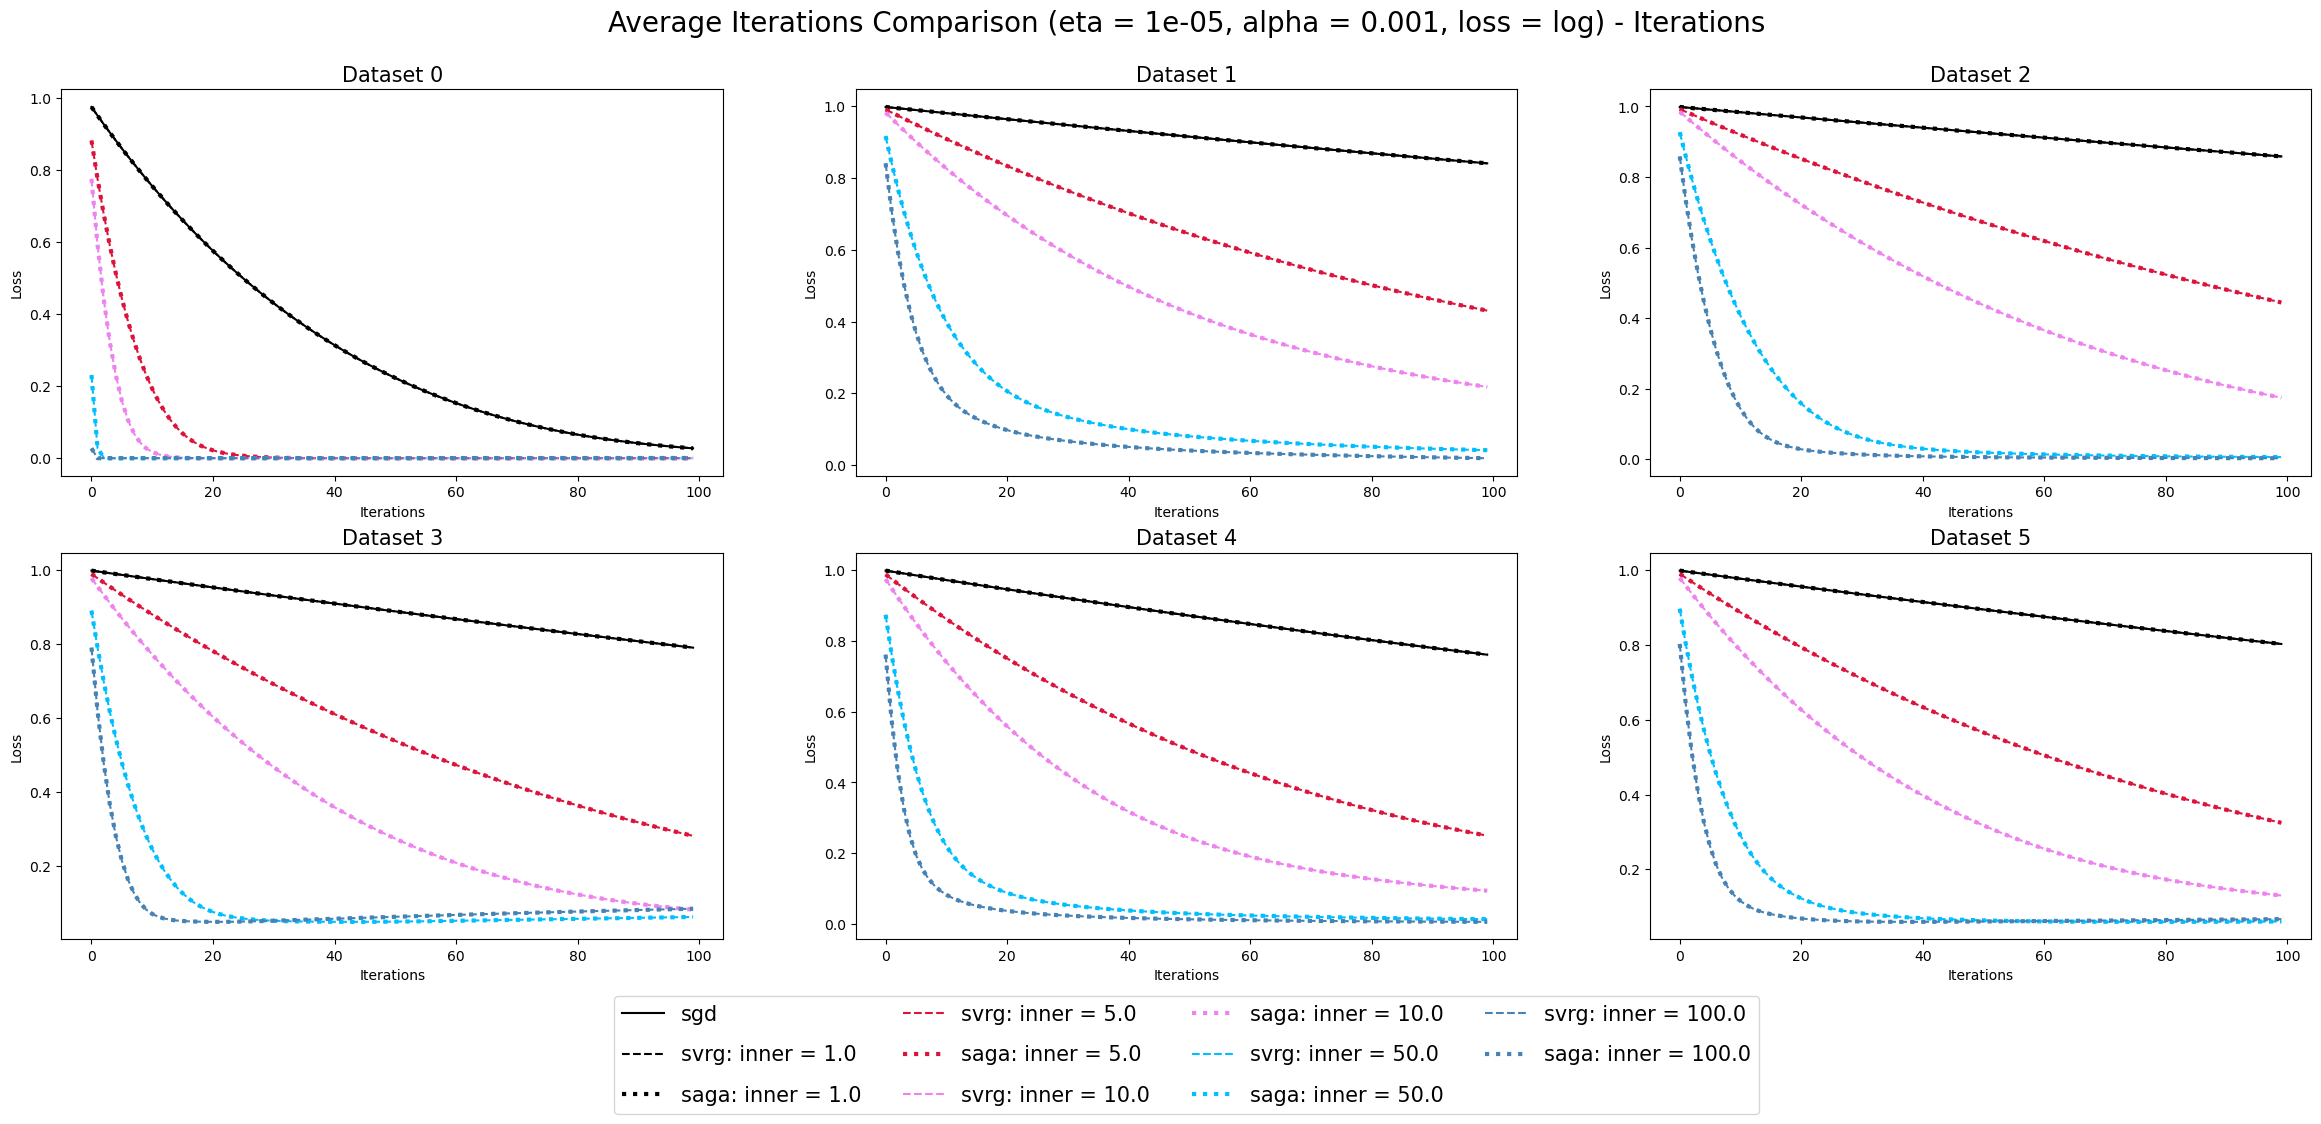

<Figure size 640x480 with 0 Axes>

In [16]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # CPU Time Subplots
    ax = fig.add_subplot(2, 3, 1 + j)

    # SGD doesn't average iterations
    cb_sgd = Callback(Xn, Yn)
    clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
        max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
    clf.fit(Xn, Yn)
    ax.plot(range(len(cb_sgd.loss)), cb_sgd.loss,
        label=f"sgd" if j == 0 else None,
        c=colours[0]) 

    for i, n_inner in enumerate(N_INNERS):
        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_svrg.loss)), cb_svrg.loss,
            label=f"svrg: inner = {n_inner}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_saga.loss)), cb_saga.loss,
            label=f"saga: inner = {n_inner}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Average Iterations Comparison (eta = {eta}, alpha = {alpha}, loss = {loss[0]}) - Iterations", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.135), labelspacing=1.0, ncols = 4)
fig.savefig("plots/inner_iterations.png", bbox_inches='tight')
plt.figure()

<Figure size 640x480 with 0 Axes>

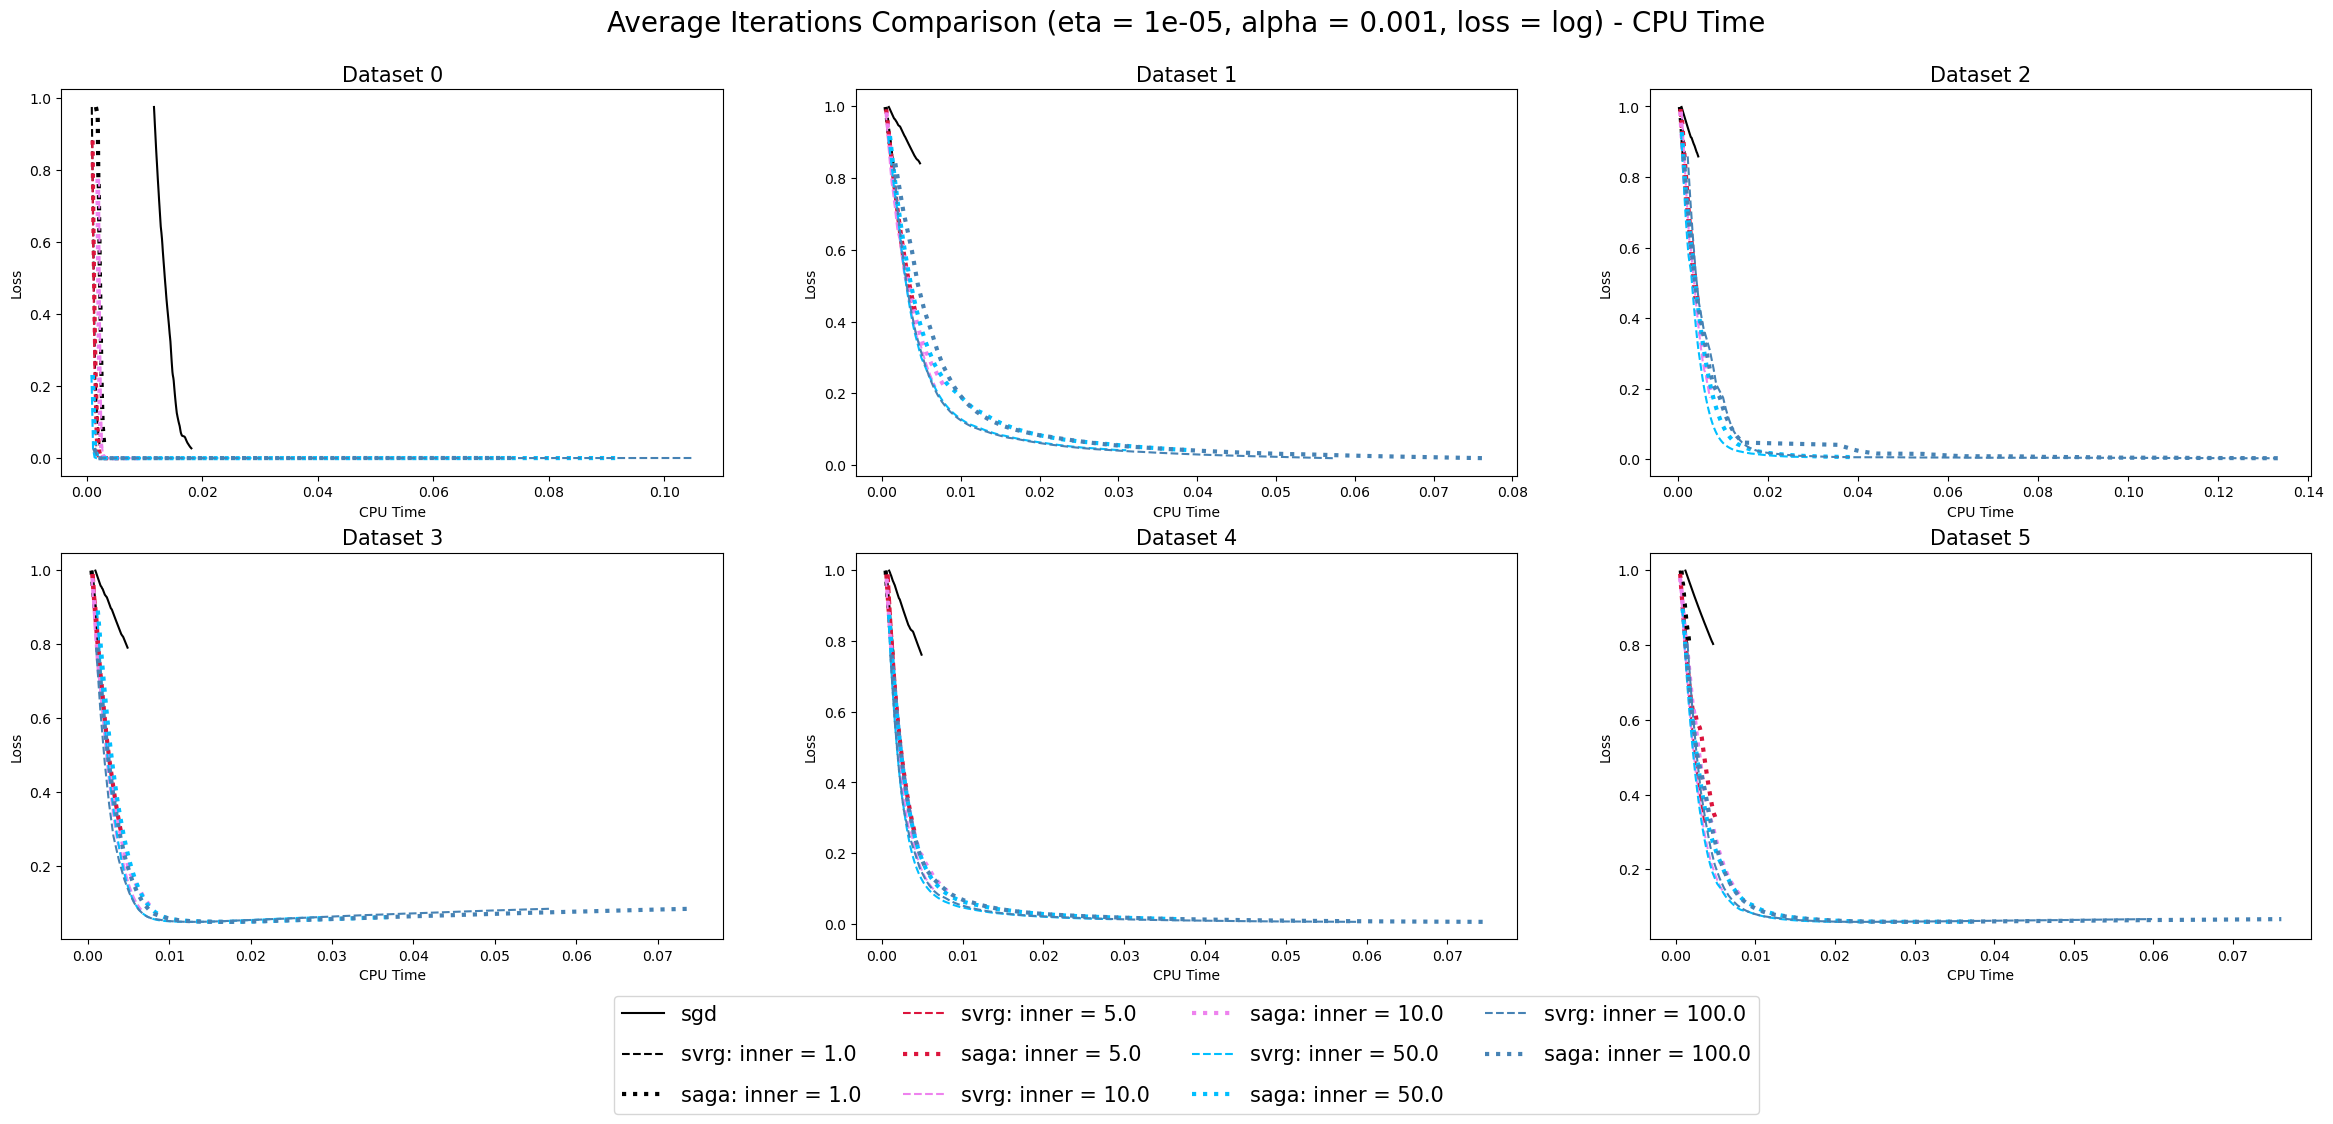

<Figure size 640x480 with 0 Axes>

In [17]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # CPU Time Subplots
    ax = fig.add_subplot(2, 3, 1 + j)

    # SGD doesn't average iterations
    cb_sgd = Callback(Xn, Yn)
    clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
        max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
    clf.fit(Xn, Yn)
    ax.plot(cb_sgd.times, cb_sgd.loss,
        label=f"sgd" if j == 0 else None,
        c=colours[0]) 

    for i, n_inner in enumerate(N_INNERS):
        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_svrg.times, cb_svrg.loss,
            label=f"svrg: inner = {n_inner}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_saga.times, cb_saga.loss,
            label=f"saga: inner = {n_inner}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("CPU Time")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Average Iterations Comparison (eta = {eta}, alpha = {alpha}, loss = {loss[0]}) - CPU Time", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.135), labelspacing=1.0, ncols = 4)
fig.savefig("plots/inner_cpu_time.png", bbox_inches='tight')
plt.figure()

#### Loss Comparison

In [18]:
# Test Values
eta = ETAS[-2]
alpha = ALPHAS[-2]
n_inner = N_INNERS[-1]

<Figure size 640x480 with 0 Axes>

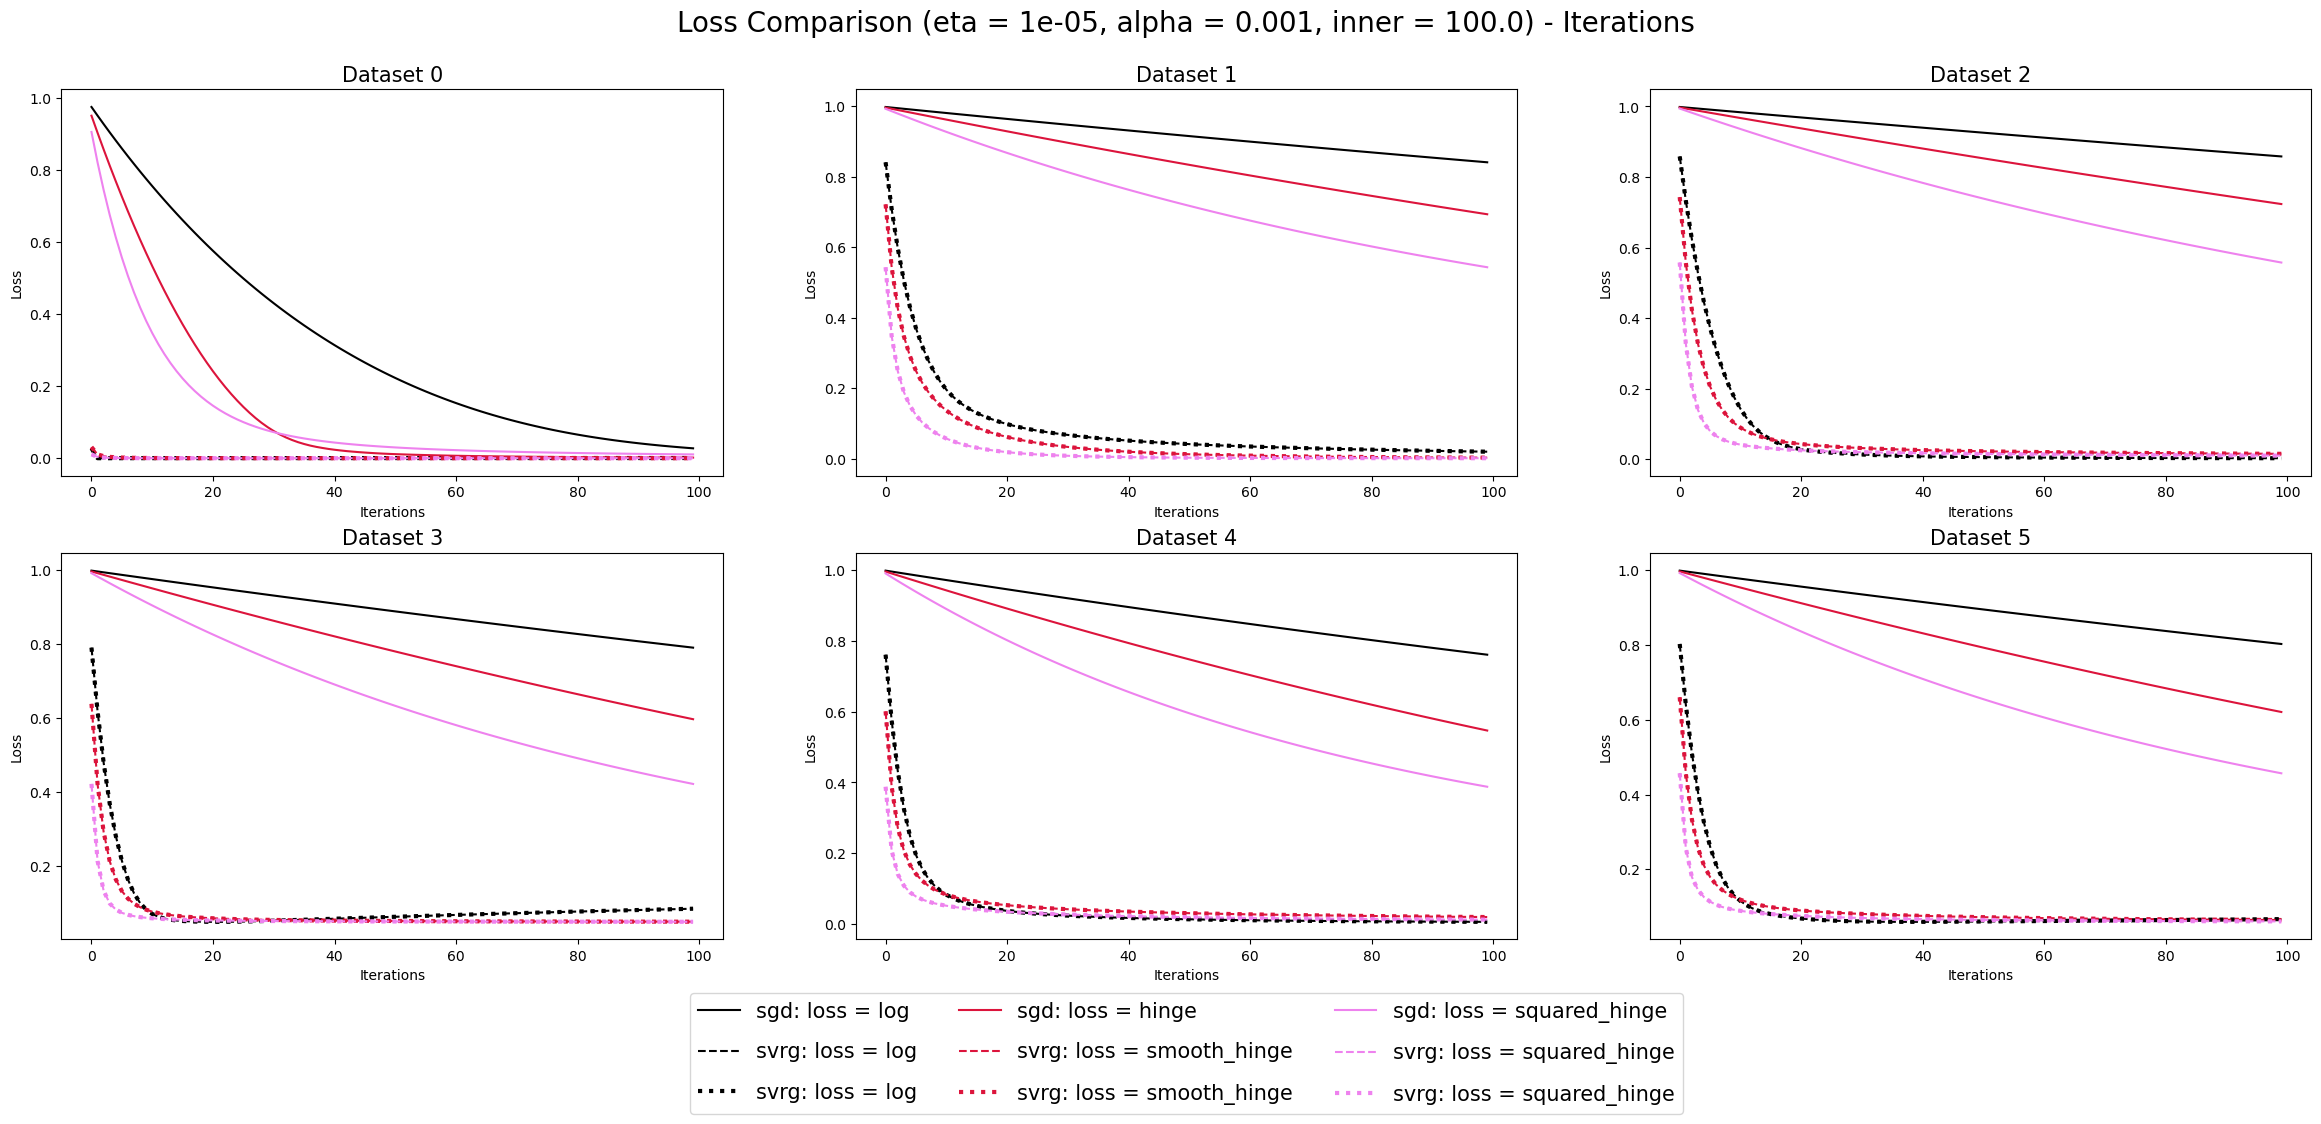

<Figure size 640x480 with 0 Axes>

In [19]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # Iteration Subplot
    ax = fig.add_subplot(2, 3, 1 + j)

    for i, loss in enumerate(LOSSES):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_sgd.loss)), cb_sgd.loss,
            label=f"sgd: loss = {loss[0]}" if j == 0 else None,
            c=colours[i])

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_svrg.loss)), cb_svrg.loss,
            label=f"svrg: loss = {loss[1]}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(range(len(cb_saga.loss)), cb_saga.loss,
            label=f"svrg: loss = {loss[1]}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Loss Comparison (eta = {eta}, alpha = {alpha}, inner = {n_inner}) - Iterations", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.135), labelspacing=1.0, ncols = 3)
fig.savefig("plots/loss_iterations.png", bbox_inches='tight')
plt.figure()

<Figure size 640x480 with 0 Axes>

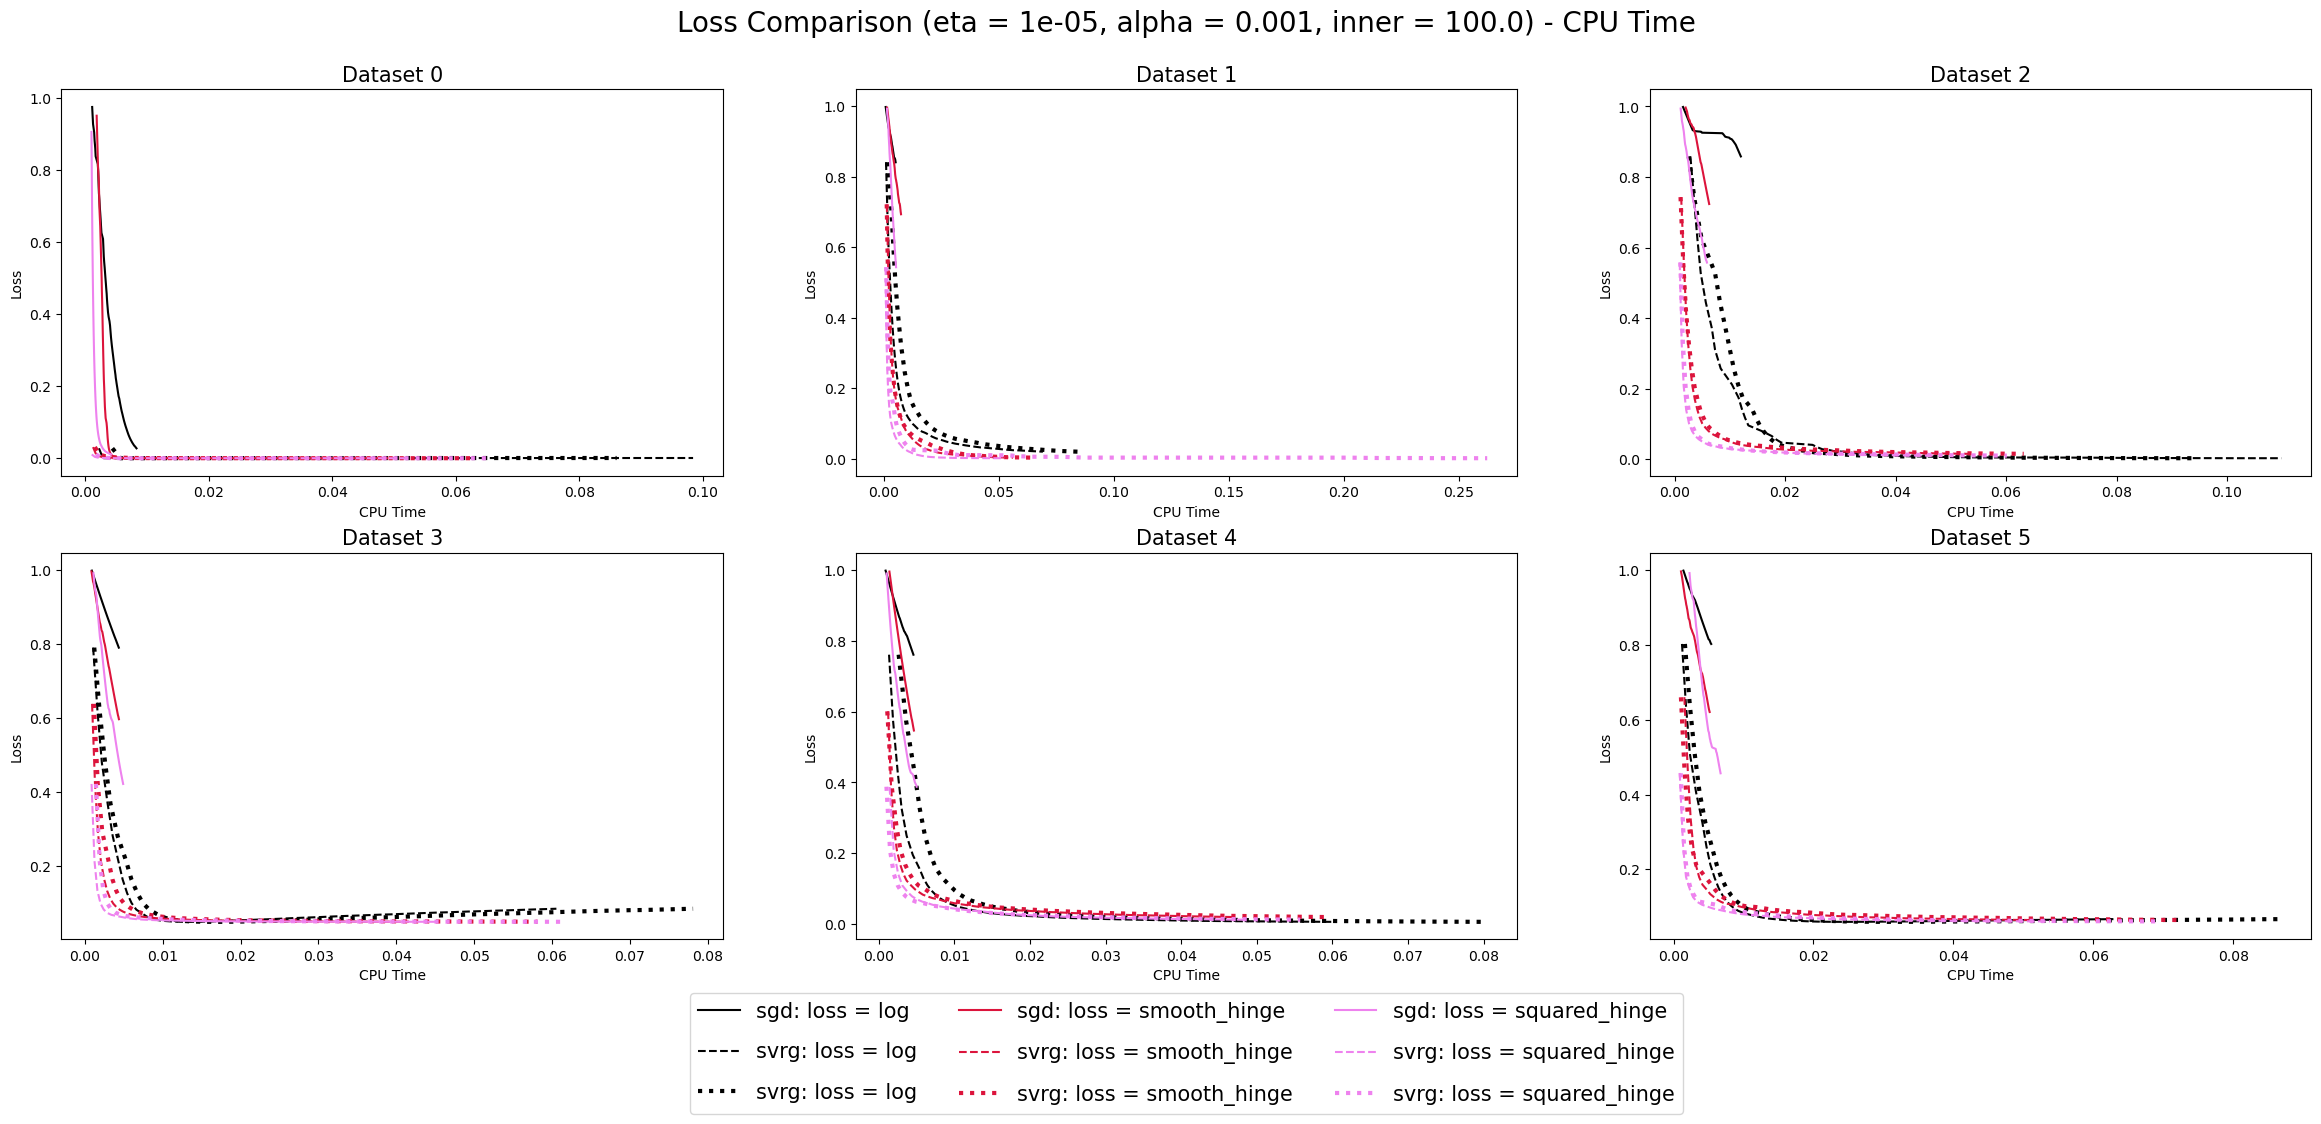

<Figure size 640x480 with 0 Axes>

In [20]:
# Setup plot
fig = plt.figure(figsize=(25, 10))
fig.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Run over all datasets
for j, tup in enumerate(DATASETS):
    Xn, Yn = tup

    # CPU Time Subplot
    ax = fig.add_subplot(2, 3, 1 + j)

    for i, loss in enumerate(LOSSES):
        cb_sgd = Callback(Xn, Yn)
        clf = SGDClassifier(loss=loss[0], alpha=alpha, eta0=eta, learning_rate='constant',
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_sgd)
        clf.fit(Xn, Yn)
        ax.plot(cb_sgd.times, cb_sgd.loss,
            label=f"sgd: loss = {loss[1]}" if j == 0 else None,
            c=colours[i])

        cb_svrg = Callback(Xn, Yn)
        clf = SVRGClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_svrg, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_svrg.times, cb_svrg.loss,
            label=f"svrg: loss = {loss[1]}" if j == 0 else None,
            c=colours[i], linestyle='dashed')
        
        cb_saga = Callback(Xn, Yn)
        clf = SAGAClassifier(loss=loss[1], alpha=alpha, eta=eta, n_inner=n_inner,
            max_iter=MAX_ITER, random_state=RANDOM_STATE, callback=cb_saga, tol=0)
        clf.fit(Xn, Yn)
        ax.plot(cb_saga.times, cb_saga.loss,
            label=f"svrg: loss = {loss[1]}" if j == 0 else None,
            c=colours[i], linestyle='dotted', linewidth=3.0)

    ax.set_title(f"Dataset {j}", fontsize=15)
    ax.set_xlabel("CPU Time")
    ax.set_ylabel("Loss")

# Format and Save Plot
fig.suptitle(f"Loss Comparison (eta = {eta}, alpha = {alpha}, inner = {n_inner}) - CPU Time", fontsize=20)
fig.legend(loc="lower center", fontsize=15, bbox_to_anchor=(0.5, -0.135), labelspacing=1.0, ncols = 3)
fig.savefig("plots/loss_cpu_time.png", bbox_inches='tight')
plt.figure()